### Import libraries

In [138]:
# import statements
%load_ext autoreload
%load_ext jupyternotify
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
/m/home/home5/56/kapoorj1/unix


### Generate data

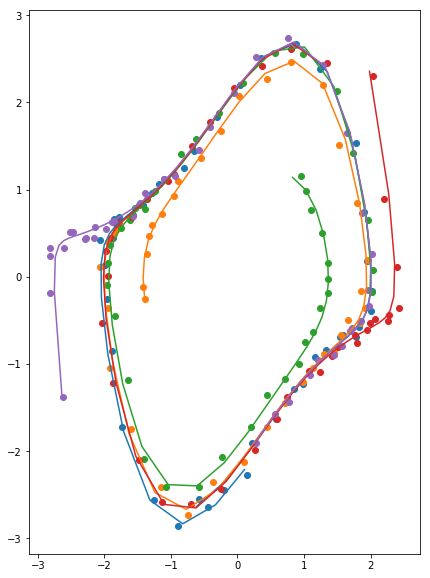

In [403]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], 1*(1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3

x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
t = torch.linspace(0., 7., 40)
# t = torch.linspace(0., 21., 120)

with torch.no_grad():
    X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.05
    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')
    plt.scatter(Y[i,:,0],Y[i,:,1])

## Implementation-1, gradients computed via sensitivities (uses autograd as a subroutine) 

### Initialize the model, parameters, variables, etc

In [164]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
Linv = torch.cholesky(K(Zt,Zt)).inverse()
U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        N = x0.shape[0]  # problem dimensionality
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
                x = xS[:,:,0].view(-1,D) # N,D
                S = xS[:,:,1:] # N,D,MD
                th = list(func.parameters())[0]
                dxs = []
                dSs = []
                for j in range(N):
                    x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
                    S_ = S[j] # D,MD
                    J = [] # accumulate columns of J here
                    R = [] # accumulate columns of R here
                    for i in range(D): # partial derivative of output dimension i 
                        with torch.set_grad_enabled(True):
                            f = func(t,x_)[0,i]
                            dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
                            J.append(dfdxth[0])
                            R.append(dfdxth[1].view(1,-1)) # 1,MD
                    J = torch.cat(J) # D,D
                    R = torch.cat(R) # D,MD
                    dS = torch.matmul(J,S_)+R # D,MD
                    dx = func(t,x_) # 1,D
                    dxs.append(dx.unsqueeze(2)) # 1,D,1
                    dSs.append(dS.unsqueeze(0)) # 1,D,MD
                dx = torch.cat(dxs) # N,D,1
                dS = torch.cat(dSs) # N,D,MD
                dxdS = torch.cat([dx,dS],2)
                return dxdS
            x0 = torch.unsqueeze(x0,2) # N,D,1
            S0 = torch.zeros(N,D,MD)
            xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
            xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
            # print(grad_output[0].shape) # N,T,D
            dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    

### Optimize

In [165]:
# optimization

logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)

    
for itr in range(500):
    optimizer.zero_grad()
    T   = min(3+itr//10, len(t))
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint_forw_sens(kreg,x0,t_)
    loss = torch.sum((Yt_-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt_)*torch.sum(logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),kreg.U)))/2
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


ValueError: func is required to be an instance of nn.Module.

### Visualize

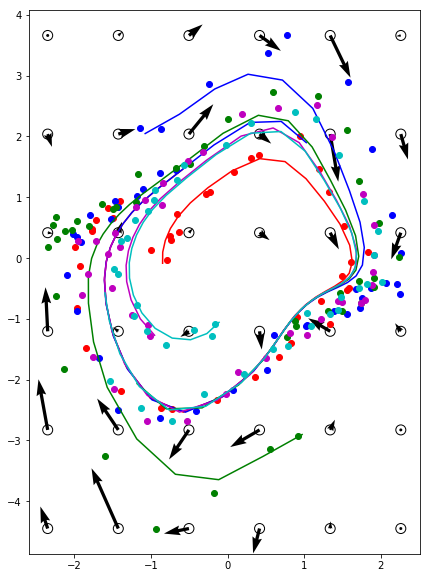

In [135]:
# plotting
xode = odeint_forw_sens(kreg, x0, t).detach().numpy()
U = kreg.U.detach().numpy()
Z = Zt.detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(Y[i,:,0],Y[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

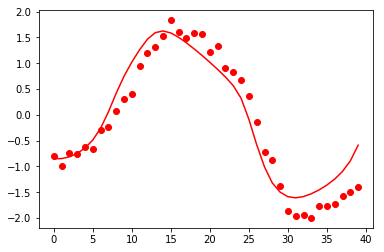

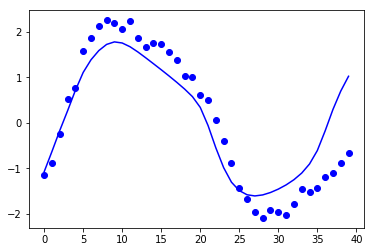

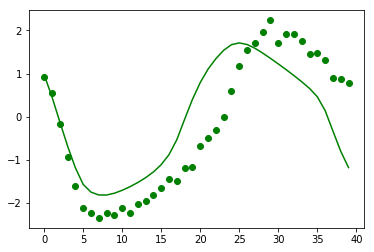

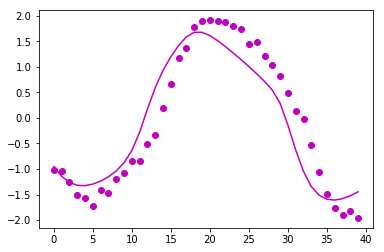

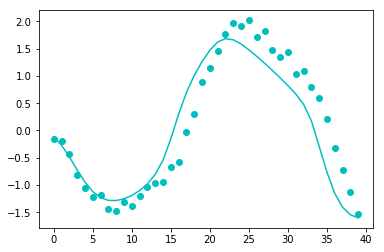

In [136]:
for i in range(min(6,xode.shape[0])):
    fig, ax = plt.subplots()
    ax.plot(Y[i,:,0],'o',color=cols[i])
    ax.plot(xode[i,:,0],'-',color=cols[i])

## Implementation-2 that uses Torch autograd, no sensitivities/adjoints 

### Initialize the model, parameters, variables, etc

In [166]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)
    

Kzzinv = K(Zt, Zt).inverse()

npode = KernelRegression()
# lbfgs = optim.LBFGS(npode.parameters(), lr=1e-3)
optimizer = optim.Adam(npode.parameters(), lr=5e-3)
# optimizer = optim.SGD(npode.parameters(), lr=3e-5)


### Optimize

In [167]:
# optimization
def closure():
    optimizer.zero_grad()
    xode = odeint(npode, x0, t).permute([1,0,2])
    loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
    loss.backward()
    return loss

    
# n_iters = 1000
n_iters = 1000

## learning rate scheduling for sgd+momentum and rmsprop
lr = 5e-4
lr_decay=0.03

## Momentum schedulin for sgd+momentum
mom_init = 0.5
mom_final = 0.99
mom_decay = 0.03

for itr in range(n_iters):
    optimizer.zero_grad()

#     for g in optimizer.param_groups:
#         g['lr'] = lr/(1+lr_decay*i)
#     for g in optimizer.param_groups:
#         g['momentum'] = mom_final - (mom_final-mom_init)/(1+mom_decay*i)

    xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn)**2) +  torch.numel(Xt)*torch.sum(npode.logsn)/D + \
        torch.sum(torch.diag(torch.mm(npode.U.t(), torch.mm(Kzzinv, npode.U))))/2
    loss.backward()
    optimizer.step()
#     lbfgs.step(closure)

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
            if torch.isnan(loss):
                %notify -m "Nan encountered in loss"
                break
            loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

Iter 0000 | Total Loss 87.553523
Iter 0001 | Total Loss 77.711588
Iter 0002 | Total Loss 68.431103
Iter 0003 | Total Loss 59.777767
Iter 0004 | Total Loss 51.814059
Iter 0005 | Total Loss 44.596556
Iter 0006 | Total Loss 38.172763
Iter 0007 | Total Loss 32.577992
Iter 0008 | Total Loss 27.832609
Iter 0009 | Total Loss 23.939709
Iter 0010 | Total Loss 20.883210
Iter 0011 | Total Loss 18.625894
Iter 0012 | Total Loss 17.107282
Iter 0013 | Total Loss 16.242399
Iter 0014 | Total Loss 15.922735
Iter 0015 | Total Loss 16.019994
Iter 0016 | Total Loss 16.392590
Iter 0017 | Total Loss 16.894700
Iter 0018 | Total Loss 17.387455
Iter 0019 | Total Loss 17.751217
Iter 0020 | Total Loss 17.897016
Iter 0021 | Total Loss 17.774579
Iter 0022 | Total Loss 17.374856
Iter 0023 | Total Loss 16.726492
Iter 0024 | Total Loss 15.887346
Iter 0025 | Total Loss 14.933205
Iter 0026 | Total Loss 13.945865
Iter 0027 | Total Loss 13.002279
Iter 0028 | Total Loss 12.165857
Iter 0029 | Total Loss 11.480537
Iter 0030 

Iter 0255 | Total Loss 5.461546
Iter 0256 | Total Loss 5.450878
Iter 0257 | Total Loss 5.440298
Iter 0258 | Total Loss 5.429803
Iter 0259 | Total Loss 5.419394
Iter 0260 | Total Loss 5.409069
Iter 0261 | Total Loss 5.398827
Iter 0262 | Total Loss 5.388667
Iter 0263 | Total Loss 5.378587
Iter 0264 | Total Loss 5.368588
Iter 0265 | Total Loss 5.358666
Iter 0266 | Total Loss 5.348821
Iter 0267 | Total Loss 5.339051
Iter 0268 | Total Loss 5.329354
Iter 0269 | Total Loss 5.319730
Iter 0270 | Total Loss 5.310175
Iter 0271 | Total Loss 5.300689
Iter 0272 | Total Loss 5.291270
Iter 0273 | Total Loss 5.281915
Iter 0274 | Total Loss 5.272622
Iter 0275 | Total Loss 5.263391
Iter 0276 | Total Loss 5.254217
Iter 0277 | Total Loss 5.245100
Iter 0278 | Total Loss 5.236037
Iter 0279 | Total Loss 5.227027
Iter 0280 | Total Loss 5.218065
Iter 0281 | Total Loss 5.209151
Iter 0282 | Total Loss 5.200282
Iter 0283 | Total Loss 5.191455
Iter 0284 | Total Loss 5.182668
Iter 0285 | Total Loss 5.173919
Iter 028

KeyboardInterrupt: 

### Visualize

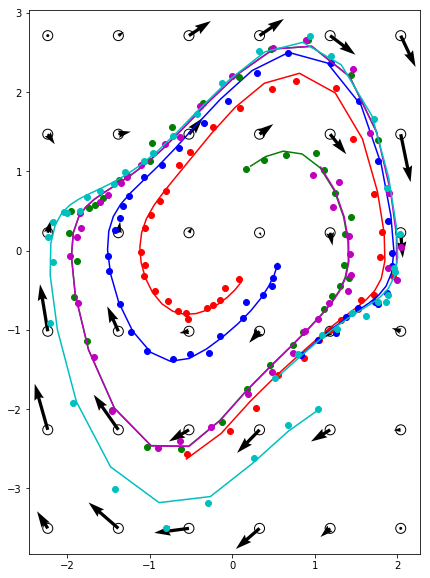

In [192]:
# plotting
xode = odeint(npode, x0, t).detach().numpy()
U = npode.U.detach().numpy()
Z = npode.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(Y[i,:,0],Y[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

In [259]:
torch.exp(npode.logsn)

tensor([0.1035, 0.1168], grad_fn=<ExpBackward>)

## Inference using MCMC

In [413]:

# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75
# ell = 1

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2)+np.log(0.05), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f|
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

kreg = KernelRegression()
Kzzinv = K(Zt, Zt).inverse()
# lbfgs = optim.LBFGS(npode.parameters(), lr=5e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)

### Inference

itr = 0


def closure(add_prior=True):
    global itr
#     T   = min(3+itr//10, len(t))
    T   = len(t)
    itr += 1
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = None  
    if add_prior:
        loss = torch.sum((Yt_-xode)**2/(2*torch.exp(kreg.logsn)**2))
        loss += torch.numel(Yt_)*torch.sum(kreg.logsn)/D
        loss += torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    else:
        loss = torch.sum((Yt_-xode)**2)
    return loss

def psgld_closure(add_prior=True):
    global itr
#     T   = min(3+itr//10, len(t))
    T   = len(t)
    itr += 1
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = None  
    if add_prior:
        loss = torch.sum((Yt_-xode)**2/(2*torch.exp(kreg.logsn)**2))
        loss += torch.numel(Yt_)*torch.sum(kreg.logsn)/D
        loss += torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    else:
        loss = torch.sum((Yt_-xode)**2)
    return loss/N


# logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
# logsn = torch.log(torch.Tensor([0.1]))
# params = kreg.parameters()
params = [kreg.U, kreg.logsn]

from samplers.langevin import MALA, MMALA, pSGLD, HAMCMC, HAMCMC2, HAMCMC3, HAMCMC4
from samplers.hamiltonian import aSGHMC

# sampler = MMALA(params, metric_obj=metric, lr=1e-4)
sampler = MALA(params, lr=1e-4, add_noise=True)
# sampler = SGLD(params, lr0=0.0001, gamma=0.55, t0=100, alpha=0.1)


chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=1000, print_loss=True)

# sampler = pSGLD(params, lr0=3e-2, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, lambda_=1e-8, alpha=0.99)
# chain, logp_array = sampler.sample(psgld_closure, burn_in=600, num_samples=1000, print_loss=True)

# sampler = HAMCMC(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-5, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_metric=True)

# sampler = HAMCMC2(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-3, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC3(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-3, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_old_lbfgs=True, add_noise=False)

# itr = 0
# lr=1e-2
# def lr_scheduler():
#     global itr
#     itr += 1
# #     if itr >500:
# #         return lr/np.sqrt((1+0.1*itr))
#     return lr

# sampler = aSGHMC(params, lr=lr, add_noise=True)
# chain, logp_array = sampler.sample(closure, burn_in=600, num_samples=1000, print_loss=True, lr_scheduler=lr_scheduler)


<class 'dict'>
Burn-in phase started
Burn-in iter 0001 | loss 2509.551741 | accepted=False
Burn-in iter 0002 | loss 2313.091244 | accepted=True
Burn-in iter 0003 | loss 2317.726999 | accepted=True
Burn-in iter 0004 | loss 2318.908386 | accepted=True
Burn-in iter 0005 | loss 2316.293553 | accepted=True
Burn-in iter 0006 | loss 2317.907914 | accepted=True
Burn-in iter 0007 | loss 2324.283471 | accepted=True
Burn-in iter 0008 | loss 2322.820319 | accepted=True
Burn-in iter 0009 | loss 2319.473299 | accepted=True
Burn-in iter 0010 | loss 2321.016930 | accepted=True
Burn-in iter 0011 | loss 2320.516054 | accepted=True
Burn-in iter 0012 | loss 2319.901002 | accepted=True
Burn-in iter 0013 | loss 2318.730509 | accepted=True
Burn-in iter 0014 | loss 2316.763162 | accepted=True
Burn-in iter 0015 | loss 2321.590207 | accepted=True
Burn-in iter 0016 | loss 2321.839186 | accepted=True
Burn-in iter 0017 | loss 2321.010882 | accepted=True
Burn-in iter 0018 | loss 2314.647733 | accepted=True
Burn-in 

Burn-in iter 0155 | loss 2333.341747 | accepted=True
Burn-in iter 0156 | loss 2331.558199 | accepted=False
Burn-in iter 0157 | loss 2331.227301 | accepted=False
Burn-in iter 0158 | loss 2332.363860 | accepted=True
Burn-in iter 0159 | loss 2326.633952 | accepted=True
Burn-in iter 0160 | loss 2318.979636 | accepted=True
Burn-in iter 0161 | loss 2324.402178 | accepted=True
Burn-in iter 0162 | loss 2324.859751 | accepted=True
Burn-in iter 0163 | loss 2326.896690 | accepted=True
Burn-in iter 0164 | loss 2332.657814 | accepted=True
Burn-in iter 0165 | loss 2324.952254 | accepted=True
Burn-in iter 0166 | loss 2325.996308 | accepted=False
Burn-in iter 0167 | loss 2318.241785 | accepted=True
Burn-in iter 0168 | loss 2321.027179 | accepted=True
Burn-in iter 0169 | loss 2326.141059 | accepted=False
Burn-in iter 0170 | loss 2320.778670 | accepted=True
Burn-in iter 0171 | loss 2326.467256 | accepted=True
Burn-in iter 0172 | loss 2329.303896 | accepted=True
Burn-in iter 0173 | loss 2330.986710 | acc

Burn-in iter 0310 | loss 2190.292450 | accepted=True
Burn-in iter 0311 | loss 2190.752942 | accepted=True
Burn-in iter 0312 | loss 2192.351101 | accepted=False
Burn-in iter 0313 | loss 2189.059877 | accepted=False
Burn-in iter 0314 | loss 2187.496199 | accepted=True
Burn-in iter 0315 | loss 2182.701377 | accepted=True
Burn-in iter 0316 | loss 2186.464606 | accepted=True
Burn-in iter 0317 | loss 2192.088024 | accepted=True
Burn-in iter 0318 | loss 2197.105427 | accepted=True
Burn-in iter 0319 | loss 2196.957784 | accepted=True
Burn-in iter 0320 | loss 2198.901976 | accepted=True
Burn-in iter 0321 | loss 2200.094234 | accepted=True
Burn-in iter 0322 | loss 2196.866632 | accepted=True
Burn-in iter 0323 | loss 2198.731391 | accepted=True
Burn-in iter 0324 | loss 2198.930467 | accepted=True
Burn-in iter 0325 | loss 2199.899959 | accepted=True
Burn-in iter 0326 | loss 2194.377471 | accepted=False
Burn-in iter 0327 | loss 2199.378902 | accepted=False
Burn-in iter 0328 | loss 2193.331393 | acc

Burn-in iter 0464 | loss 2191.531385 | accepted=True
Burn-in iter 0465 | loss 2193.728723 | accepted=True
Burn-in iter 0466 | loss 2195.838904 | accepted=False
Burn-in iter 0467 | loss 2191.697352 | accepted=True
Burn-in iter 0468 | loss 2195.702454 | accepted=True
Burn-in iter 0469 | loss 2200.768661 | accepted=True
Burn-in iter 0470 | loss 2196.064532 | accepted=True
Burn-in iter 0471 | loss 2185.957094 | accepted=True
Burn-in iter 0472 | loss 2188.530490 | accepted=True
Burn-in iter 0473 | loss 2185.589606 | accepted=True
Burn-in iter 0474 | loss 2181.980309 | accepted=True
Burn-in iter 0475 | loss 2181.232951 | accepted=True
Burn-in iter 0476 | loss 2182.642274 | accepted=True
Burn-in iter 0477 | loss 2182.637819 | accepted=True
Burn-in iter 0478 | loss 2183.989560 | accepted=True
Burn-in iter 0479 | loss 2183.217925 | accepted=True
Burn-in iter 0480 | loss 2183.885146 | accepted=True
Burn-in iter 0481 | loss 2182.676734 | accepted=True
Burn-in iter 0482 | loss 2179.515408 | accept

Burn-in iter 0619 | loss 2161.617275 | accepted=True
Burn-in iter 0620 | loss 2164.069955 | accepted=True
Burn-in iter 0621 | loss 2163.302188 | accepted=True
Burn-in iter 0622 | loss 2161.711751 | accepted=False
Burn-in iter 0623 | loss 2157.874725 | accepted=True
Burn-in iter 0624 | loss 2157.171200 | accepted=True
Burn-in iter 0625 | loss 2162.877901 | accepted=True
Burn-in iter 0626 | loss 2166.621296 | accepted=False
Burn-in iter 0627 | loss 2161.584018 | accepted=True
Burn-in iter 0628 | loss 2165.252734 | accepted=True
Burn-in iter 0629 | loss 2169.105617 | accepted=True
Burn-in iter 0630 | loss 2162.812114 | accepted=True
Burn-in iter 0631 | loss 2163.176163 | accepted=True
Burn-in iter 0632 | loss 2157.626340 | accepted=True
Burn-in iter 0633 | loss 2157.377616 | accepted=True
Burn-in iter 0634 | loss 2154.704723 | accepted=True
Burn-in iter 0635 | loss 2153.627978 | accepted=True
Burn-in iter 0636 | loss 2154.032241 | accepted=True
Burn-in iter 0637 | loss 2149.692544 | accep

Burn-in iter 0774 | loss 2063.461529 | accepted=True
Burn-in iter 0775 | loss 2062.486984 | accepted=False
Burn-in iter 0776 | loss 2062.829093 | accepted=False
Burn-in iter 0777 | loss 2064.113509 | accepted=True
Burn-in iter 0778 | loss 2068.852811 | accepted=True
Burn-in iter 0779 | loss 2067.805067 | accepted=True
Burn-in iter 0780 | loss 2067.773618 | accepted=True
Burn-in iter 0781 | loss 2066.800984 | accepted=True
Burn-in iter 0782 | loss 2064.387646 | accepted=True
Burn-in iter 0783 | loss 2061.614215 | accepted=True
Burn-in iter 0784 | loss 2064.979523 | accepted=True
Burn-in iter 0785 | loss 2066.828189 | accepted=True
Burn-in iter 0786 | loss 2066.133722 | accepted=True
Burn-in iter 0787 | loss 2067.757078 | accepted=True
Burn-in iter 0788 | loss 2064.401534 | accepted=True
Burn-in iter 0789 | loss 2068.397622 | accepted=False
Burn-in iter 0790 | loss 2069.145281 | accepted=True
Burn-in iter 0791 | loss 2068.181420 | accepted=True
Burn-in iter 0792 | loss 2060.565843 | acce

Burn-in iter 0929 | loss 2046.392534 | accepted=False
Burn-in iter 0930 | loss 2045.964863 | accepted=True
Burn-in iter 0931 | loss 2047.665843 | accepted=False
Burn-in iter 0932 | loss 2046.162020 | accepted=True
Burn-in iter 0933 | loss 2040.329345 | accepted=True
Burn-in iter 0934 | loss 2039.370730 | accepted=False
Burn-in iter 0935 | loss 2037.151700 | accepted=True
Burn-in iter 0936 | loss 2035.596898 | accepted=True
Burn-in iter 0937 | loss 2034.123271 | accepted=True
Burn-in iter 0938 | loss 2035.563299 | accepted=True
Burn-in iter 0939 | loss 2040.311286 | accepted=True
Burn-in iter 0940 | loss 2040.140800 | accepted=True
Burn-in iter 0941 | loss 2038.327114 | accepted=True
Burn-in iter 0942 | loss 2036.026211 | accepted=False
Burn-in iter 0943 | loss 2037.248352 | accepted=True
Burn-in iter 0944 | loss 2034.619912 | accepted=True
Burn-in iter 0945 | loss 2032.840043 | accepted=True
Burn-in iter 0946 | loss 2031.777399 | accepted=False
Burn-in iter 0947 | loss 2032.971641 | ac

Burn-in iter 1084 | loss 2058.737220 | accepted=True
Burn-in iter 1085 | loss 2056.101317 | accepted=True
Burn-in iter 1086 | loss 2050.586474 | accepted=True
Burn-in iter 1087 | loss 2050.272423 | accepted=True
Burn-in iter 1088 | loss 2050.229454 | accepted=True
Burn-in iter 1089 | loss 2045.534607 | accepted=True
Burn-in iter 1090 | loss 2048.939109 | accepted=True
Burn-in iter 1091 | loss 2052.882745 | accepted=False
Burn-in iter 1092 | loss 2058.737929 | accepted=True
Burn-in iter 1093 | loss 2063.616939 | accepted=True
Burn-in iter 1094 | loss 2061.865943 | accepted=True
Burn-in iter 1095 | loss 2056.407888 | accepted=True
Burn-in iter 1096 | loss 2054.080096 | accepted=True
Burn-in iter 1097 | loss 2059.827038 | accepted=True
Burn-in iter 1098 | loss 2057.837793 | accepted=True
Burn-in iter 1099 | loss 2054.849406 | accepted=True
Burn-in iter 1100 | loss 2052.516044 | accepted=True
Burn-in iter 1101 | loss 2054.459300 | accepted=True
Burn-in iter 1102 | loss 2054.930622 | accept

Burn-in iter 1239 | loss 2029.011583 | accepted=True
Burn-in iter 1240 | loss 2028.245340 | accepted=True
Burn-in iter 1241 | loss 2026.316109 | accepted=True
Burn-in iter 1242 | loss 2024.003455 | accepted=True
Burn-in iter 1243 | loss 2024.087271 | accepted=True
Burn-in iter 1244 | loss 2025.065630 | accepted=True
Burn-in iter 1245 | loss 2024.567274 | accepted=True
Burn-in iter 1246 | loss 2021.693604 | accepted=True
Burn-in iter 1247 | loss 2023.976539 | accepted=True
Burn-in iter 1248 | loss 2025.970069 | accepted=False
Burn-in iter 1249 | loss 2024.626555 | accepted=True
Burn-in iter 1250 | loss 2024.002428 | accepted=True
Burn-in iter 1251 | loss 2021.171232 | accepted=True
Burn-in iter 1252 | loss 2015.279064 | accepted=True
Burn-in iter 1253 | loss 2014.594086 | accepted=False
Burn-in iter 1254 | loss 2013.084044 | accepted=True
Burn-in iter 1255 | loss 2011.793864 | accepted=True
Burn-in iter 1256 | loss 2008.405822 | accepted=True
Burn-in iter 1257 | loss 2008.603736 | accep

Burn-in iter 1394 | loss 1978.637591 | accepted=False
Burn-in iter 1395 | loss 1980.765244 | accepted=True
Burn-in iter 1396 | loss 1974.638436 | accepted=True
Burn-in iter 1397 | loss 1967.069793 | accepted=True
Burn-in iter 1398 | loss 1965.779228 | accepted=True
Burn-in iter 1399 | loss 1966.094432 | accepted=True
Burn-in iter 1400 | loss 1963.766316 | accepted=True
Burn-in iter 1401 | loss 1961.274275 | accepted=True
Burn-in iter 1402 | loss 1959.828070 | accepted=True
Burn-in iter 1403 | loss 1958.239685 | accepted=True
Burn-in iter 1404 | loss 1958.095728 | accepted=True
Burn-in iter 1405 | loss 1954.582135 | accepted=True
Burn-in iter 1406 | loss 1955.068997 | accepted=True
Burn-in iter 1407 | loss 1953.268679 | accepted=True
Burn-in iter 1408 | loss 1951.185463 | accepted=True
Burn-in iter 1409 | loss 1954.173695 | accepted=False
Burn-in iter 1410 | loss 1953.507610 | accepted=True
Burn-in iter 1411 | loss 1957.096835 | accepted=True
Burn-in iter 1412 | loss 1957.822530 | accep

Burn-in iter 1549 | loss 1955.885526 | accepted=True
Burn-in iter 1550 | loss 1953.891456 | accepted=True
Burn-in iter 1551 | loss 1955.695723 | accepted=True
Burn-in iter 1552 | loss 1955.960864 | accepted=True
Burn-in iter 1553 | loss 1956.033061 | accepted=True
Burn-in iter 1554 | loss 1954.735446 | accepted=True
Burn-in iter 1555 | loss 1956.952342 | accepted=False
Burn-in iter 1556 | loss 1956.641355 | accepted=True
Burn-in iter 1557 | loss 1958.694474 | accepted=True
Burn-in iter 1558 | loss 1958.617258 | accepted=False
Burn-in iter 1559 | loss 1957.592973 | accepted=False
Burn-in iter 1560 | loss 1956.845167 | accepted=True
Burn-in iter 1561 | loss 1961.172604 | accepted=True
Burn-in iter 1562 | loss 1959.165446 | accepted=True
Burn-in iter 1563 | loss 1961.255030 | accepted=True
Burn-in iter 1564 | loss 1962.025353 | accepted=True
Burn-in iter 1565 | loss 1964.860319 | accepted=True
Burn-in iter 1566 | loss 1964.643621 | accepted=True
Burn-in iter 1567 | loss 1964.751529 | acce

Burn-in iter 1704 | loss 1980.776462 | accepted=True
Burn-in iter 1705 | loss 1982.152060 | accepted=False
Burn-in iter 1706 | loss 1971.981157 | accepted=True
Burn-in iter 1707 | loss 1973.195922 | accepted=True
Burn-in iter 1708 | loss 1969.669437 | accepted=True
Burn-in iter 1709 | loss 1966.049631 | accepted=False
Burn-in iter 1710 | loss 1964.781462 | accepted=True
Burn-in iter 1711 | loss 1962.194001 | accepted=True
Burn-in iter 1712 | loss 1967.759911 | accepted=True
Burn-in iter 1713 | loss 1964.804427 | accepted=True
Burn-in iter 1714 | loss 1968.256564 | accepted=True
Burn-in iter 1715 | loss 1966.434231 | accepted=True
Burn-in iter 1716 | loss 1962.238072 | accepted=True
Burn-in iter 1717 | loss 1965.482396 | accepted=True
Burn-in iter 1718 | loss 1967.332133 | accepted=False
Burn-in iter 1719 | loss 1964.849601 | accepted=True
Burn-in iter 1720 | loss 1957.397698 | accepted=True
Burn-in iter 1721 | loss 1962.102781 | accepted=False
Burn-in iter 1722 | loss 1959.706101 | acc

Burn-in iter 1859 | loss 1914.157481 | accepted=True
Burn-in iter 1860 | loss 1914.112309 | accepted=True
Burn-in iter 1861 | loss 1912.777603 | accepted=True
Burn-in iter 1862 | loss 1910.616018 | accepted=True
Burn-in iter 1863 | loss 1908.026774 | accepted=True
Burn-in iter 1864 | loss 1907.269240 | accepted=True
Burn-in iter 1865 | loss 1903.941502 | accepted=True
Burn-in iter 1866 | loss 1904.261285 | accepted=True
Burn-in iter 1867 | loss 1907.033102 | accepted=False
Burn-in iter 1868 | loss 1904.044383 | accepted=True
Burn-in iter 1869 | loss 1903.578796 | accepted=True
Burn-in iter 1870 | loss 1902.798194 | accepted=True
Burn-in iter 1871 | loss 1902.962037 | accepted=True
Burn-in iter 1872 | loss 1897.851731 | accepted=True
Burn-in iter 1873 | loss 1897.013240 | accepted=True
Burn-in iter 1874 | loss 1896.888003 | accepted=True
Burn-in iter 1875 | loss 1898.321067 | accepted=True
Burn-in iter 1876 | loss 1898.766491 | accepted=True
Burn-in iter 1877 | loss 1897.451622 | accept

Sample iter 0014 | loss 1850.965092 | accepted=True
Sample iter 0015 | loss 1849.836902 | accepted=True
Sample iter 0016 | loss 1848.650379 | accepted=False
Sample iter 0017 | loss 1849.242333 | accepted=True
Sample iter 0018 | loss 1848.804721 | accepted=True
Sample iter 0019 | loss 1847.519063 | accepted=True
Sample iter 0020 | loss 1842.604581 | accepted=True
Sample iter 0021 | loss 1840.341102 | accepted=True
Sample iter 0022 | loss 1840.346361 | accepted=True
Sample iter 0023 | loss 1841.501953 | accepted=True
Sample iter 0024 | loss 1842.372564 | accepted=True
Sample iter 0025 | loss 1839.727305 | accepted=True
Sample iter 0026 | loss 1839.910363 | accepted=True
Sample iter 0027 | loss 1841.137622 | accepted=True
Sample iter 0028 | loss 1836.384323 | accepted=True
Sample iter 0029 | loss 1838.781205 | accepted=True
Sample iter 0030 | loss 1840.441013 | accepted=False
Sample iter 0031 | loss 1842.574317 | accepted=False
Sample iter 0032 | loss 1844.460854 | accepted=True
Sample it

KeyboardInterrupt: 

### Visualization

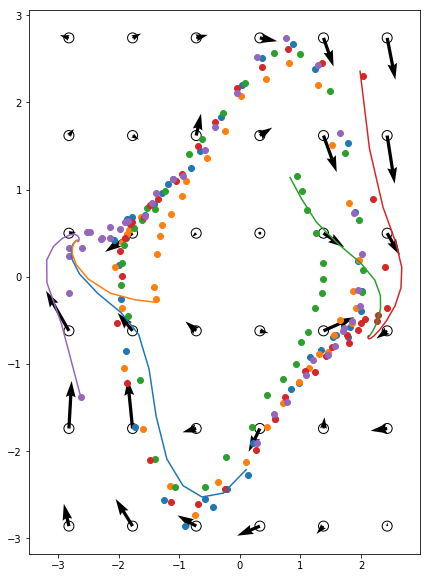

In [414]:
chain = sampler.samples[-40:]
# plotting
mean_U = np.mean([i[0][0][0] for i in chain if i[1]], axis=0)

kreg.U.data = torch.from_numpy(mean_U)
mean_logsn = np.mean([i[0][0][1] for i in chain if i[1]], axis=0)
kreg.logsn.data = torch.from_numpy(mean_logsn)
xode = odeint(kreg, x0, t).detach().numpy()
# U = kreg.U.detach().numpy()
U = mean_U
Z = kreg.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    color=np.random.rand(3)
    plt.scatter(Y[i,:,0],Y[i,:,1],)
    plt.plot(xode[i,:,0],xode[i,:,1],'-')

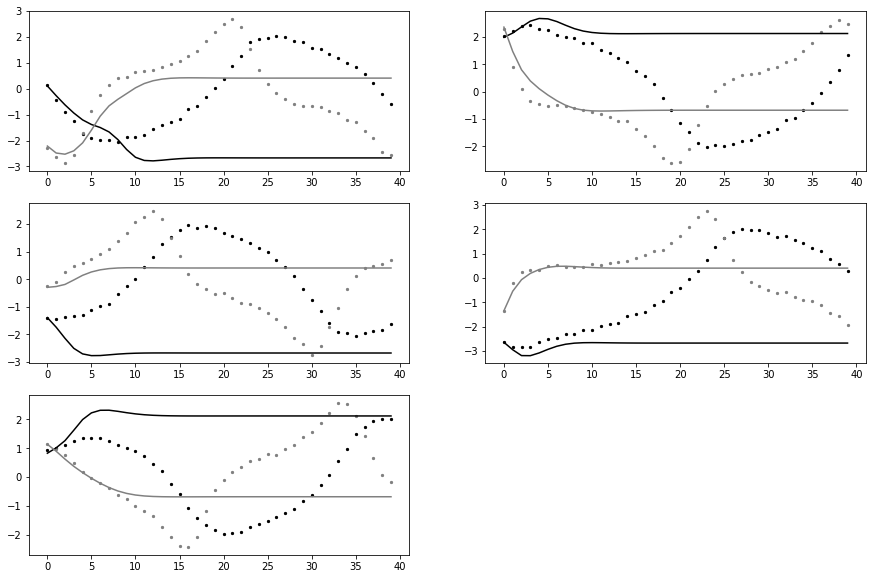

In [415]:
fig, ax = plt.subplots(nrows=(min(6,xode.shape[0])+1)//2, ncols=2, figsize=(15,10))
axes = [ax[i][j] for j in range(2) for i in range(len(ax))]
for i in range(min(6,xode.shape[0])):
    axes[i].scatter(range(len(Y[i,:,0])),Y[i,:,0],color='k',s=5)
    axes[i].plot(xode[i,:,0],'-',color='k')
    axes[i].scatter(range(len(Y[i,:,1])),Y[i,:,1],color='gray',s=5)
    axes[i].plot(xode[i,:,1],'-',color='gray')
for i in range(min(6,xode.shape[0]), len(axes)):
    fig.delaxes(axes[i])

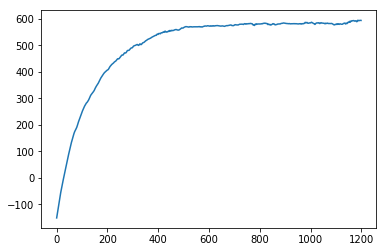

In [417]:
plt.plot(logp_array[400:])

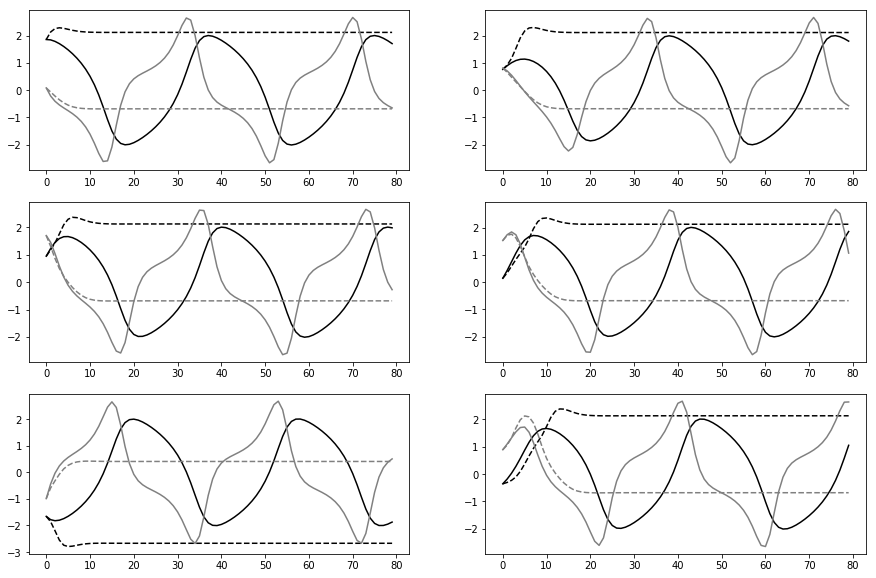

In [418]:
R_= 2
x0_ = torch.from_numpy(2*R_*ss.uniform.rvs(size=[10,2])-R_)
t_ = torch.linspace(0., 28., 160)
xode_gp = odeint(kreg, x0_, t_).detach().numpy()
xode_gp = np.transpose(xode_gp,[1,0,2])

xode_real = odeint(VDP(), x0_, t_).detach().numpy()
xode_real = np.transpose(xode_real,[1,0,2])

num_plots = 6
fig, ax = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15,10))
axes = [ax[i][j] for j in range(2) for i in range(len(ax))]
for i in range(num_plots):
    axes[i].plot(xode_real[i,0:80,0],'-',color='k')
    axes[i].plot(xode_gp[i,0:80,0],'--',color='k')
    axes[i].plot(xode_real[i,0:80,1],'-',color='gray')
    axes[i].plot(xode_gp[i,0:80,1],'--',color='gray')
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])
    

In [ ]:
plt.plot([np.mean(np.exp(i[0][0][1])) for i in sampler.samples[:] if i[1]])